## Overview
***
*A chatbot or chatterbot is a software application used to conduct an on-line chat conversation via text or text-to-speech, in lieu of providing direct contact with a live human agent chatbot is a type of software that can help human by automating conversations and interact with them through messaging platforms. here are different approaches and tools that you can use when building chatbots. Depending on the use case you want to address, some technologies are more appropriate than others. Combining artificial intelligence forms such as natural language processing, machine learning, and semantic understanding may be the best option to achieve the desired results.*
***


## How to build a Chatbot for our task?
***
ChatBots are usually Task specific means if there a chatbot which serves only food delivery app have trained on a dataset which
completely different from the dataset on which chatbot which serves online healthcare app. Similary, for this kaggle problem
we have provided with movie dataset which may feel that its not specific to any task, but actually it is specific to how people
will interect generally as these movie dialogues are nothing but daily life conversation between people however, that chatbot
may reply things which sounds too much dramatic and filmy like some dialogue of Tom cruise, shah rukh khan etc.

We can approch this problem by applying Neural network models like encoder-decoder architecture with some attention mechanism.
***

In [1]:
import numpy as np
import codecs
import tensorflow as tf
import pandas as pd
import ast
import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
# import seaborn as sns
import pandas as pd
import re
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')

In [2]:
dialogs = pd.read_csv('dialogs_expanded.csv')

In [3]:
print(dialogs.shape)
dialogs.head()

(139409, 7)


,Unnamed: 0,question,answer,question_as_int,answer_as_int,question_len,answer_len
0,1,"Well, I thought we'd start with pronunciation,...",Not the hacking and gagging and spitting part....,"[54, 67, 74, 74, 12, 1, 40, 1, 82, 70, 77, 83,...","[45, 77, 82, 1, 82, 70, 67, 1, 70, 63, 65, 73,...",71,55
1,2,Not the hacking and gagging and spitting part....,Okay... then how 'bout we try out some French ...,"[45, 77, 82, 1, 82, 70, 67, 1, 70, 63, 65, 73,...","[46, 73, 63, 87, 14, 14, 14, 1, 82, 70, 67, 76...",55,73
2,3,You're asking me out. That's so cute. What's ...,Forget it.,"[56, 77, 83, 8, 80, 67, 1, 63, 81, 73, 71, 76,...","[37, 77, 80, 69, 67, 82, 1, 71, 82, 14]",62,10
3,4,"No, no, it's my fault -- we didn't have a prop...",Cameron.,"[45, 77, 12, 1, 76, 77, 12, 1, 71, 82, 8, 81, ...","[34, 63, 75, 67, 80, 77, 76, 14]",65,8
4,9,"Gosh, if only we could find Kat a boyfriend...",Let me see what I can do.,"[38, 77, 81, 70, 12, 1, 71, 68, 1, 77, 76, 74,...","[43, 67, 82, 1, 75, 67, 1, 81, 67, 67, 1, 85, ...",46,25


### We have given:-
1. ID: serial number
2. question: string representing questions
3. answer: string representing answers
4. question_as_int: tokenized question
5. answer_as_int: tokenized answer
6. question_len: no. of words in question
7. answer_len: no. of words in answer

##### Main concern is (question, answer) pair columns only, on which I'll train the model

In [3]:
data = dialogs[['question', 'answer']]
data.head()

,question,answer
0,"Well, I thought we'd start with pronunciation,...",Not the hacking and gagging and spitting part....
1,Not the hacking and gagging and spitting part....,Okay... then how 'bout we try out some French ...
2,You're asking me out. That's so cute. What's ...,Forget it.
3,"No, no, it's my fault -- we didn't have a prop...",Cameron.
4,"Gosh, if only we could find Kat a boyfriend...",Let me see what I can do.


##### Cheking if there is null or not

In [89]:
data.isnull().any()

question    False
answer      False
dtype: bool

##### Fetching all words which are like won't, aren't etc just to understand variety as we will convert all those to their proper forms

In [75]:
total_strings = data['question'].values.tolist() + data['answer'].values.tolist()
all_strings = " ".join(total_strings)
pattern = re.compile(r"[\w]*'[\w]*")
matchings = re.findall(pattern, all_strings)

In [80]:
set(matchings)

{"stompin'",
 "Hannah's",
 "you've",
 "watchin'",
 "yo'",
 "Ellie's",
 "Sheriff's",
 "cables're",
 "twins'",
 "They'd",
 "Gruber's",
 "bunny's",
 "m'a",
 "Valhere's",
 "Hunsecker's",
 "halo'd",
 "Harrison's",
 "Eduard's",
 "'fools",
 "'ems",
 "'dirty",
 "home'",
 "Roeder's",
 "l'il",
 "Andy's",
 "'job",
 "La'chiem",
 "'jerk",
 "b'fore",
 "baker's",
 "ss'trakyona",
 "publicity's",
 "'late",
 "But'cha",
 "N'Yawk",
 "Bustin'",
 "Viv'",
 "Diva's",
 "Strader's",
 "we're",
 "Keaton's",
 "Nobody's",
 "O'Reilly",
 "'National",
 "'Hmmm",
 "Roy'll",
 "twiddlin'",
 "THEY'RE",
 "farmers'",
 "going'",
 "stealin'",
 "Kimberly's",
 "Nothin's",
 "PG's",
 "Martini's",
 "'Earl",
 "closed'",
 "rulin'",
 "A'ight",
 "'Bout",
 "Sheldon's",
 "Laurie's",
 "O'Donnel",
 "Chamberlain's",
 "Merrill's",
 "Candy's",
 "fantasies'",
 "why'd",
 "'Hildy",
 "Theodosia's",
 "Escobar'll",
 "Federation'll",
 "She'd",
 "River's",
 "grandfather's",
 "Would'a",
 "Beck's",
 "rhino'd",
 "Lan's",
 "drugstore's",
 "gentlemen's",


## Preprocessing
Removing special characters and doing decontraction

In [4]:
def decontractions(phrase):
    #specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase

def preprocess(text):
    text = text.lower()
    text = decontractions(text)
    text = re.sub('[^A-Za-z0-9 ]+', '', text)
    return text


data['question'] = data['question'].apply(preprocess)
data['answer'] = data['answer'].apply(preprocess)
data.head()

,question,answer
0,well i thought we would start with pronunciati...,not the hacking and gagging and spitting part ...
1,not the hacking and gagging and spitting part ...,okay then how bout we try out some french cuis...
2,you are asking me out that is so cute what is...,forget it
3,no no it is my fault we did not have a proper...,cameron
4,gosh if only we could find kat a boyfriend,let me see what i can do


In [7]:
q_lengths = data['question'].str.split().apply(len)
a_lengths = data['answer'].str.split().apply(len)

In [8]:
from tqdm import tqdm 
all_ques = " ".join(data['question'].values)
all_ans = " ".join(data['answer'].values)
word_cnt_a = {}
for i in tqdm(all_ans.split()): word_cnt_a[i] = word_cnt_a.get(i, 0) + 1
word_cnt_q = {}
for i in tqdm(all_ques.split()): word_cnt_q[i] = word_cnt_q.get(i, 0) + 1

100%|███████████████████████████████████████████████████████████████████| 1087736/1087736 [00:00<00:00, 2594961.63it/s]


In [26]:
word_ordered_a = sorted(word_cnt_a, key=lambda x: word_cnt_a[x], reverse=True)
top_20_a = word_ordered_a[:20]
cnts_20_a = [word_cnt_a[i] for i in top_20_a]

word_ordered_q = sorted(word_cnt_q, key=lambda x: word_cnt_q[x], reverse=True)
top_20_q = word_ordered_q[:20]
cnts_20_q = [word_cnt_q[i] for i in top_20_q]


In [18]:
import seaborn as sns

sns.set(rc={'figure.figsize':(11.7,8.27)})
def plot(top_words, counts):    
    fig, ax = plt.subplots()

    # Save the chart so we can loop through the bars below.
    bars = ax.bar(
        x=np.arange(len(top_words)),
        height=counts,
        tick_label=top_words
    )

    # Axis formatting.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('#DDDDDD')
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    ax.yaxis.grid(True, color='#EEEEEE')
    ax.xaxis.grid(False)

    # Add text annotations to the top of the bars.
    bar_color = bars[0].get_facecolor()
    for bar in bars:
      ax.text(
          bar.get_x() + bar.get_width() / 2,
          bar.get_height() + 0.3,
          round(bar.get_height(), 1),
          horizontalalignment='center',
          color=bar_color,
          weight='bold'
      )

    # Add labels and a title. Note the use of `labelpad` and `pad` to add some
    # extra space between the text and the tick labels.
    ax.set_xlabel('Word', labelpad=15, color='#333333')
    ax.set_ylabel('Count', labelpad=15, color='#333333')
    ax.set_title("Most usual words in reply/answers", pad=15, color='#333333',
                 weight='bold')

    fig.tight_layout()

## Let's have a look on the distribution of words in the dataset

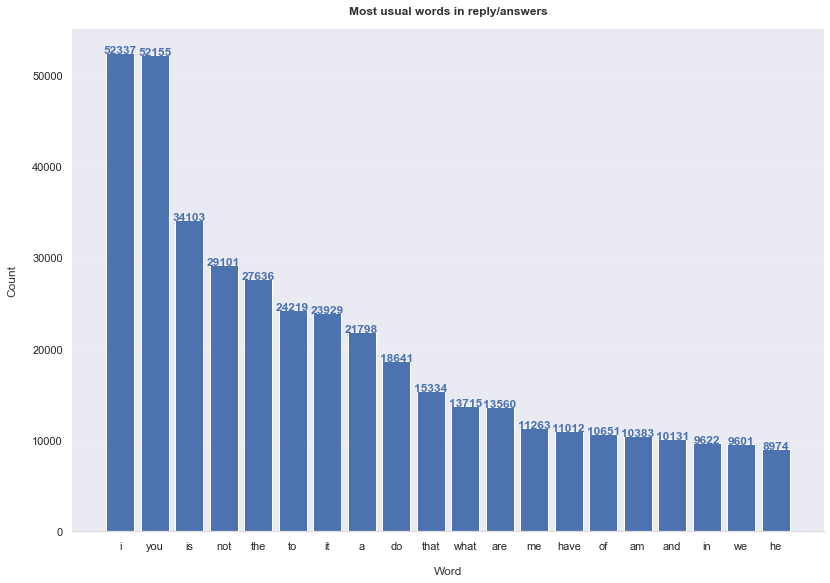

In [11]:

plot(top_20_a, cnts_20_a) 

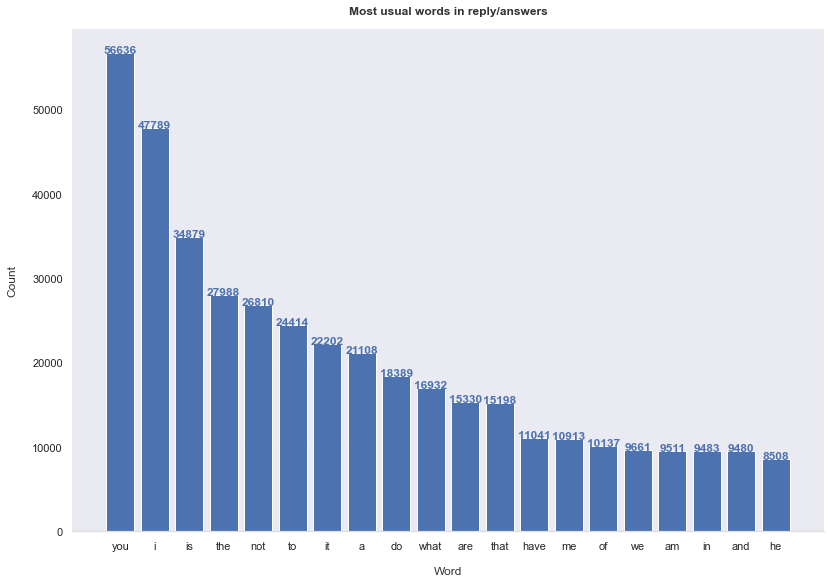

In [27]:

plot(top_20_q, cnts_20_q) 

In [36]:
word_ordered_a = sorted(word_cnt_a, key=lambda x: word_cnt_a[x], reverse=True)
top_20_a = []
for i in word_ordered_a:
    if len(top_20_a) == 20: break
    if len(i) >= 5:
        top_20_a.append(i)
cnts_20_a = [word_cnt_a[i] for i in top_20_a]

word_ordered_q = sorted(word_cnt_q, key=lambda x: word_cnt_q[x], reverse=True)
top_20_q = []
for i in word_ordered_q:
    if len(top_20_q) == 20: break
    if len(i) >= 5:
        top_20_q.append(i)
cnts_20_q = [word_cnt_q[i] for i in top_20_q]


##### Most used words having length > 5, questions

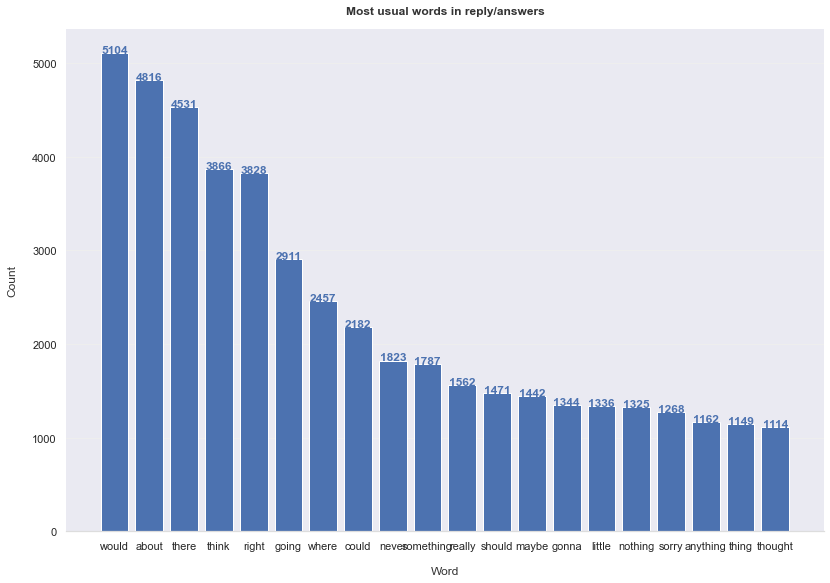

In [34]:
plot(top_20_a, cnts_20_a) 

#### Most used words having length > 5, questions

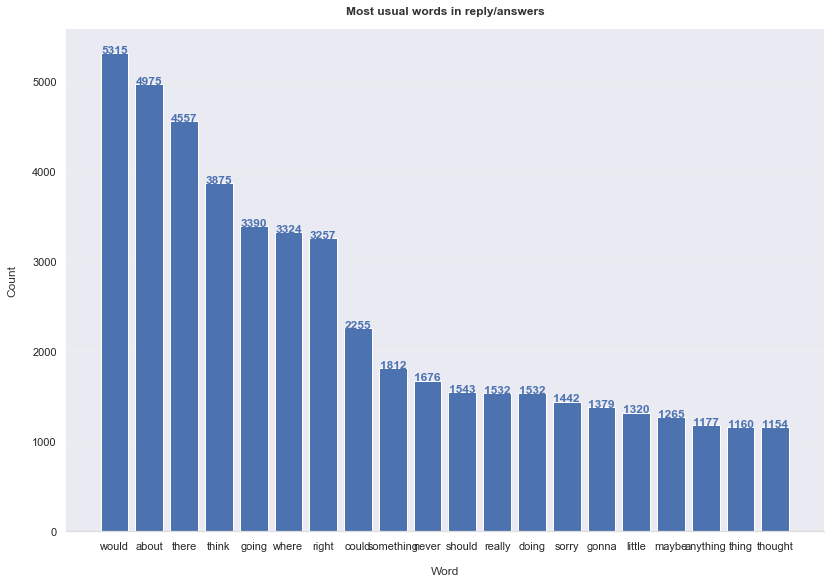

In [37]:

plot(top_20_q, cnts_20_q) 

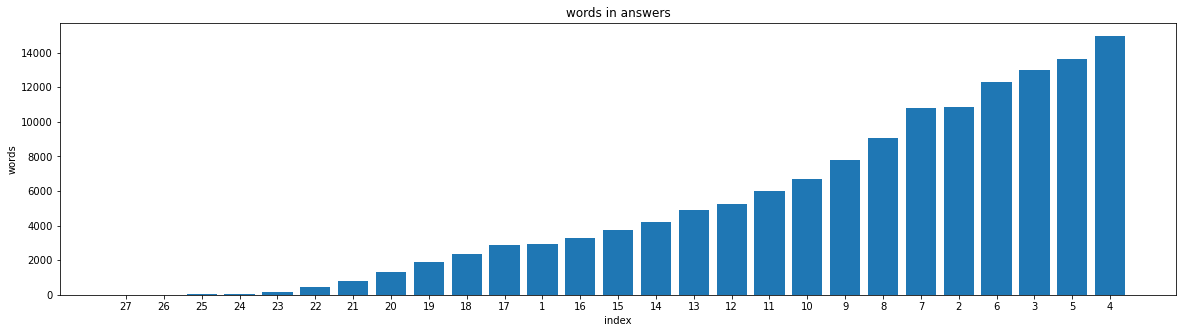

In [10]:
answer_count = data['answer'].str.split().apply(len).value_counts()
word_dict = dict(answer_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[1]))
ind = np.arange(len(word_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(word_dict.values()))

plt.ylabel('words')
plt.xlabel('index')
plt.title('words in answers')
plt.xticks(ind, list(word_dict.keys()))
plt.show()

#### Sentence lengths are more likely to occure in range (2-7)

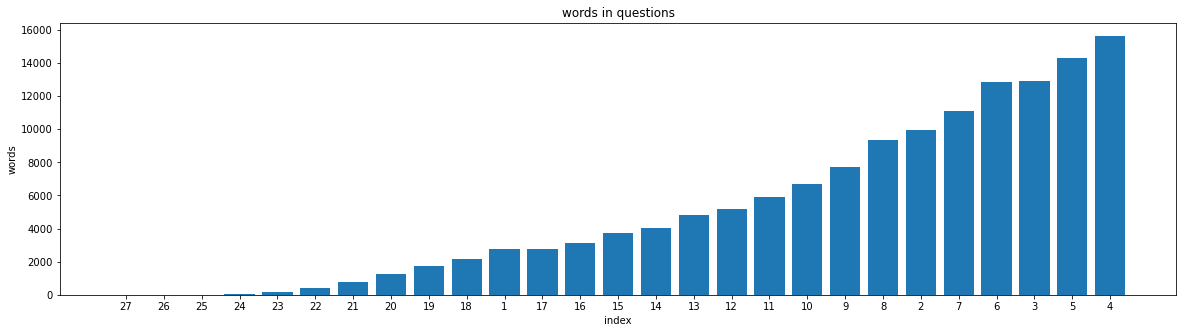

In [14]:
answer_count = data['question'].str.split().apply(len).value_counts()
word_dict = dict(answer_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[1]))
ind = np.arange(len(word_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(word_dict.values()))

plt.ylabel('words')
plt.xlabel('index')
plt.title('words in questions')
plt.xticks(ind, list(word_dict.keys()))
plt.show()

#### Sentence lengths are more likely to occure in range (2-7)

##### Minimum no. of words required to explain maximum no. of document in the corpus for answer set

In [8]:
for i in range(0,101,10):
    print(i,np.percentile(q_lengths, i))
print("="*80)
for i in range(90,101):
    print(i,np.percentile(q_lengths, i))
print("="*80)
for i in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print(i,np.percentile(q_lengths, i))

0 1.0
10 3.0
20 4.0
30 5.0
40 6.0
50 7.0
60 8.0
70 10.0
80 12.0
90 15.0
100 27.0
90 15.0
91 15.0
92 16.0
93 16.0
94 17.0
95 17.0
96 18.0
97 19.0
98 19.0
99 20.0
100 27.0
99.1 21.0
99.2 21.0
99.3 21.0
99.4 21.0
99.5 21.0
99.6 22.0
99.7 22.0
99.8 22.0
99.9 23.0
100 27.0


##### Minimum no. of words required to explain maximum no. of document in the corpus for question set

In [9]:
for i in range(0,101,10):
    print(i,np.percentile(a_lengths, i))
print("="*80)
for i in range(90,101):
    print(i,np.percentile(a_lengths, i))
print("="*80)
for i in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print(i,np.percentile(a_lengths, i))

0 1.0
10 3.0
20 4.0
30 5.0
40 6.0
50 7.0
60 8.0
70 10.0
80 12.0
90 15.0
100 27.0
90 15.0
91 16.0
92 16.0
93 17.0
94 17.0
95 18.0
96 18.0
97 19.0
98 20.0
99 21.0
100 27.0
99.1 21.0
99.2 21.0
99.3 21.0
99.4 21.0
99.5 21.0
99.6 22.0
99.7 22.0
99.8 22.0
99.9 23.0
100 27.0


##### In both Questions and answers 99.9 percent can be covered with 23 word length and for 100 percent we need 27 words As the difference between 100 and 99.9 percentile is very less to there no significant benifit of using 23 words only, so for tokenization we will take all the 27 words for both questions and answers.

## I'm going to try Simple encoder decoder for training at first, For that I need to Do some preprocessing!

#### Adding \<start>, \<end> tokens, for to apply one time-shifted technique!

In [9]:
data['answer_in'] = '<start> ' + data['answer'].astype(str)
data['answer_out'] = data['answer'].astype(str) + ' <end>'
data.head()

,question,answer,answer_in,answer_out
0,well i thought we would start with pronunciati...,not the hacking and gagging and spitting part ...,<start> not the hacking and gagging and spitti...,not the hacking and gagging and spitting part ...
1,not the hacking and gagging and spitting part ...,okay then how bout we try out some french cuis...,<start> okay then how bout we try out some fre...,okay then how bout we try out some french cuis...
2,you are asking me out that is so cute what is...,forget it,<start> forget it,forget it <end>
3,no no it is my fault we did not have a proper...,cameron,<start> cameron,cameron <end>
4,gosh if only we could find kat a boyfriend,let me see what i can do,<start> let me see what i can do,let me see what i can do <end>


In [10]:
data_final = data.drop(['answer'], axis=1)
data_final.head()

,question,answer_in,answer_out
0,well i thought we would start with pronunciati...,<start> not the hacking and gagging and spitti...,not the hacking and gagging and spitting part ...
1,not the hacking and gagging and spitting part ...,<start> okay then how bout we try out some fre...,okay then how bout we try out some french cuis...
2,you are asking me out that is so cute what is...,<start> forget it,forget it <end>
3,no no it is my fault we did not have a proper...,<start> cameron,cameron <end>
4,gosh if only we could find kat a boyfriend,<start> let me see what i can do,let me see what i can do <end>


### Train test split of the dataset

In [11]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(data_final, test_size=0.2)

### Adding  \<end> in Answer_in so that it can be tokenized by tokenizer!

In [12]:
train.iloc[0]['answer_in']= str(train.iloc[0]['answer_in'])+' <end>'
train.iloc[0]['answer_out']= str(train.iloc[0]['answer_out'])+' <end>'

### Saving data set for to use in training!, in the next notebook.

In [ ]:
 import joblib
# joblib.dump(data, "train")
# joblib.dump(validation, "validation")
# train = joblib.load("train")
# validation = joblib.load("validation")

In [139]:

# i, cnt = 0, 0
# a = [5, 19, 1, 8]
# a.sort(reverse=True)
# s = sum(a)
# h = s/2
# while(i != len(a)-1):
#     while(a[i] >= a[i+1] and s > h):
#         s = s - a[i]
#         a[i] = a[i]/2
#         s = s + a[i]
#         cnt += 1          
#     i += 1
#     if s <= h: break
        
#     if i == len(a)-1:
#         cnt += 1
#         break 

In [42]:
cnt

5